In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function

In [258]:
exponential_count =2
parameter_count = exponential_count*2+1

Load a model or creat a new one?

In [259]:
load = True
model_path ='models/2024-01-08_16-14-55_2exp_params_205_points_50/model.keras'

In [260]:
df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')
# df = pd.read_csv('measurements/E_4_20ms_20231103_14_55_46.csv', sep=', ')
df.head()

C:\Users\crpdn\AppData\Local\Temp\ipykernel_19564\431649043.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('measurements/C_4_1000_20231213_14_15_50.csv', sep=', ')


,Ch1(mA),Ch2(mA),Ch3(mA),Ch4(mA),Ch5(mA),Ch6(mA),Ch7(mA),Ch8(mA),Ch9(mA),Ch10(mA),...,Ch14(mA),Ch15(mA),Ch16(mA),Channel state,On time,Off time,Pulse number,Pattern,Time,Probeflag
0,0,0,0,0.03421,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,1,1/1000,0.087664,False
1,0,0,0,0.04888,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,2,1/1000,0.182584,False
2,0,0,0,0.06354,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,3,1/1000,0.283189,False
3,0,0,0,0.08309,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,4,1/1000,0.376060,False
4,0,0,0,0.09775,0,0,0,0,0,0,...,0,0,0,1000000000000,75,22,5,1/1000,0.469858,False


In [261]:
df = df[ ['Pattern','Time','Ch4(mA)','On time', 'Off time']]
df = df.rename(columns={'Ch4(mA)': 'Current'})
df = df.drop(df.index[:50*10])
df = df.iloc[1000:1050]
df.head()

,Pattern,Time,Current,On time,Off time
1500,31/1000,225.214643,0.4448,47,68
1501,31/1000,225.328495,0.4839,47,68
1502,31/1000,225.445176,0.5034,47,68
1503,31/1000,225.561147,0.5279,47,68
1504,31/1000,225.674205,0.5474,47,68


In [262]:
target_points = 50
cutoff_current_min = 0
must_be_growth = False
must_be_decay = False
min_gradient =0
max_final_gradient = 1

Text(0.5, 1.0, 'Data to be modeled')

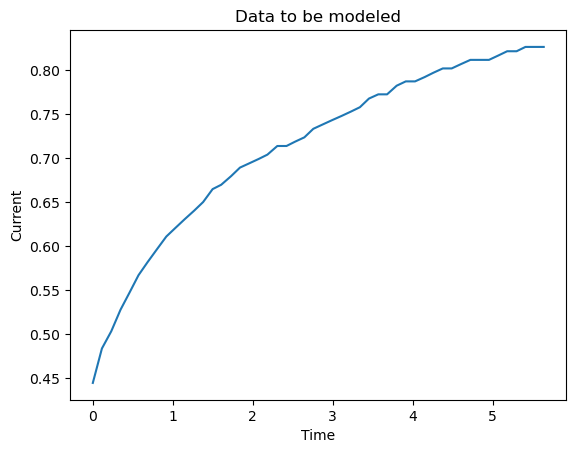

In [263]:
grouped = df.groupby('Pattern')
list_of_dfs = [group for _, group in grouped]
list_of_dfs_fixed = []
for data in list_of_dfs:    
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    points = len(y_current)    
    #(data.loc[0,'Off time'])
    if len(y_current) != target_points:
        print(points)
        continue
    assert x_time.shape == y_current.shape
    assert points == target_points
    if np.min(y_current)>cutoff_current_min and np.max(np.abs(np.gradient(y_current,y_current.index)))>min_gradient and np.min(np.abs(np.gradient(y_current,y_current.index)[:-10]))<max_final_gradient:
        if must_be_growth:
            if y_current.iloc[0]<y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)
        elif   must_be_decay:
            if y_current.iloc[0]>y_current.iloc[-1]:
                plt.plot(x_time, y_current, '-')
                list_of_dfs_fixed.append(data)          
        else:
            plt.plot(x_time, y_current, '-')
            list_of_dfs_fixed.append(data)
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Data to be modeled')

In [264]:
#initialize array of expected shape
X_data = np.zeros((len(list_of_dfs_fixed),3))
#initialize array of expected shape
y_data = np.zeros((len(list_of_dfs_fixed), points, 2))

for i in range(len(list_of_dfs_fixed)):
    data = list_of_dfs_fixed[i]
    x_time = data['Time']-np.min(data['Time'])
    y_current = data['Current']
    
    if len(y_current) != target_points:
        print(points)
        continue
    if np.max(y_current)>cutoff_current_min:
        label = np.column_stack((x_time,y_current))  
        y_data[i,:,:]= label
        features =  np.array([np.min(y_current.values), data['On time'].iloc[0], data['Off time'].iloc[0]])
        X_data[i,:] = features
    prev_on_time = data['On time'].iloc[0]
    prev_off_time = data['Off time'].iloc[0]

print(f"X shape:{X_data.shape}")
print(f"y shape:{y_data.shape}")


X shape:(1, 3)
y shape:(1, 50, 2)


In [265]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.0, train_size=1.0)
X_train = X_data
y_train = y_data

In [266]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)



In [267]:
import keras

import tensorflow.keras.backend as K

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the specified task.

    Parameters:
    - y_true: Ground truth values, of shape (batch_size, 2, N).
    - y_pred: Predicted values, of shape (batch_size, 7,N).

    Returns:
    - loss: Scalar value representing the mean loss over the batch.
    """

    # Extract x and y values from y_true
    x_values = y_true[:,:,0]  # Shape: (batch_size, N)
    y_values = y_true[:,:,1]  # Shape: (batch_size, N)
    
    function_values = tf.zeros_like(x_values)
    for i in range(int((y_pred.shape[2]-1)/2)):
        temp_val= y_pred[:, :,i]*i * K.exp(-(x_values) * y_pred[:, :,i+1]*i)
        function_values = function_values+ temp_val
    function_values = function_values+y_pred[:,:,-1]
    
    # square absolute error
    diff = (y_values -function_values) 
    squared_diff = tf.math.square(diff)
    mse = tf.math.reduce_sum(squared_diff, axis=-1)


    # diff = function_values - y_values
    # # print(diff)
    # # Take the square of the differences
    # squared_diff = K.square(diff)

    # slope_comparison = 0.0
    # for i in range(y_true.shape[2]-1):
    #     x_diff = x_values[:,i+1]-x_values[:,i]  
    #     function_slope = (function_values[:,i+1]-function_values[:,i])/x_diff 
    #     true_slope= (y_values[:,i+1]-y_values[:,i])/x_diff
    #     slope_comparison += tf.math.square(true_slope- function_slope)      

    # square relative error
    # diff = (y_values -function_values) / (y_values+0.0001) #K.maximum(y_values, y_values+0.00001)
    # squared_diff = tf.math.square(diff)
    # mse = tf.math.reduce_sum(squared_diff, axis=-1)

    loss = mse #+ slope_comparison
    # loss = K.mean(squared_diff, axis=-1)
    return loss
 

def create_nn():
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    layers_dense = keras.layers.Dense(10, 'linear')(inputs)
    layers_dense2 = keras.layers.Dense(10, 'linear')(layers_dense)
    # layers_dense3 = keras.layers.Dense(20, 'linear')(layers_dense2)
    # layers_dense4 = keras.layers.Dense(20, 'linear')(layers_dense3)
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    parameters = keras.layers.Dense(parameter_count)(layers_dense2)
    # Expand parameters to have same shape as y_true
    expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=expanded_parameters, name="current_function_prediction")

In [268]:
if load:
    model = keras.models.load_model(model_path, custom_objects={'custom_loss':custom_loss})
else:
    model = create_nn()

model.summary()

Model: "current_function_prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3)]               0         
                                                                 
 dense_12 (Dense)            (None, 10)                40        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 5)                 55        
                                                                 
 repeat_vector_4 (RepeatVec  (None, 50, 5)             0         
 tor)                                                            
                                                                 
Total params: 205 (820.00 Byte)
Trainable params: 205 (820.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_

In [269]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer=sgd, #'adam'
                  loss=custom_loss)
    


number_of_epochs = 40


class MyEarlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self, *args, **kw):
        super().__init__(*args, **kw)
        self.baseline_attained = False

    def on_epoch_end(self, epoch, logs=None):
        if not self.baseline_attained:
            current = self.get_monitor_value(logs)
            if current is None:
                return

            if self.monitor_op(current, self.baseline):
                if self.verbose > 0:
                    print('Baseline attained.')
                self.baseline_attained = True
            else:
                return

        super(MyEarlyStopping, self).on_epoch_end(epoch, logs)

earlystopper = MyEarlyStopping(monitor="loss", patience=0, baseline = 0.01, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                              factor=0.8, 
                              patience=5, 
                              min_lr=1e-6)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim !=0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [270]:
history = model.fit(X_train, y_train,
                    batch_size=1,
                    epochs=number_of_epochs,
                    # validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/40


1/1 - 0s - loss: 3535.0703 - lr: 0.0010 - 479ms/epoch - 479ms/step
Epoch 2/40
1/1 - 0s - loss: 1507.5890 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 3/40
1/1 - 0s - loss: 517.3630 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 4/40
1/1 - 0s - loss: 124.0875 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 5/40
1/1 - 0s - loss: 51.4809 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 6/40
1/1 - 0s - loss: 55.9213 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 7/40
1/1 - 0s - loss: 23.0240 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 8/40
1/1 - 0s - loss: 36.8627 - lr: 0.0010 - 3ms/epoch - 3ms/step
Epoch 9/40
1/1 - 0s - loss: 14.5392 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 10/40
1/1 - 0s - loss: 29.2158 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 11/40
1/1 - 0s - loss: 11.3862 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 12/40
1/1 - 0s - loss: 25.5898 - lr: 0.0010 - 3ms/epoch - 3ms/step
Epoch 13/40
1/1 - 0s - loss: 9.9778 - lr: 0.0010 - 2ms/epoch - 2ms/step
Epoch 14/40
1/1 - 0s - loss: 23.5194 - lr: 0.0010 - 2ms/epoch 

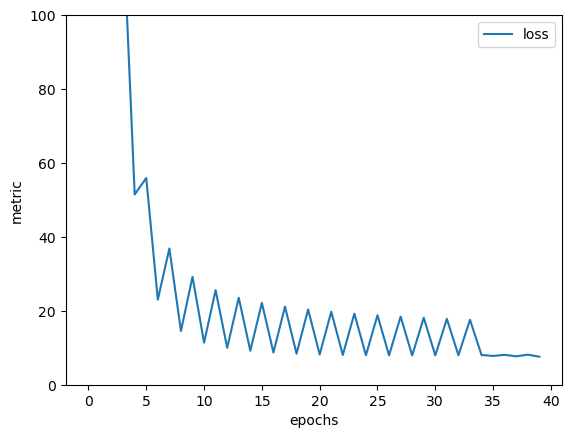

In [271]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss'],100)

In [276]:
# Save the model
import os
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# model.save('models/'+filename)


folder_path = f'models/{current_date}_{exponential_count}exp_params_{model.count_params()}_points_{points}'
os.makedirs(folder_path, exist_ok=True)
model = keras.models.load_model(model_path, custom_objects={'custom_loss':custom_loss})
model.save(folder_path+'/model.h5')

In [273]:
# make prediction on test data
y_train_prediction = model.predict(X_train)

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 17ms/step


Text(0.5, 1.0, 'Relative Error of test data prediction')

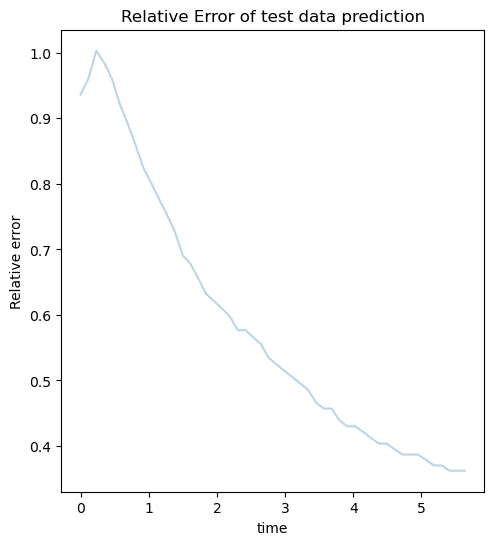

In [274]:
plt.figure(figsize=(12, 6))

y_train_prediction = model.predict(X_train)

# from matplotlib.pyplot import cm
# color = iter(cm.rainbow(np.linspace(0, 1, X_test.shape[0]-5)))
plt.subplot(1, 2, 1)
for test_entry_index in range(X_train.shape[0]):
    y_true = y_train[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0], -(y_true[:,1]- model_function.exponential_function_param_specific(y_true[:,0], param_predicted))/y_true[:,1], '-', color = 'C0', alpha = 0.3, )


plt.xlabel('time')
plt.ylabel('Relative error')
plt.title('Relative Error of test data prediction')


Relative error plots

1/1 [==============================] - 0s 17ms/step


Text(0.5, 1.0, 'True vs prediction')

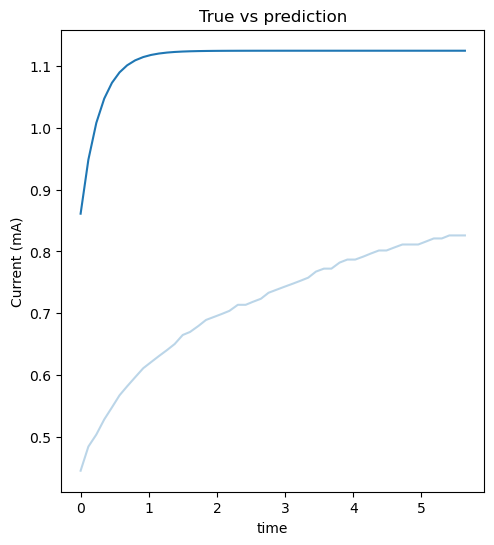

In [275]:
plt.figure(figsize=(12, 6))

y_train_prediction = model.predict(X_train)

plt.subplot(1, 2, 1)
for test_entry_index in range(X_train.shape[0]):
    y_true = y_train[test_entry_index,:,:]
    param_predicted = y_train_prediction[test_entry_index,0 ,: ]
    plt.plot(y_true[:,0], y_true[:,1], '-', color = 'C0', alpha = 0.3, )
    plt.plot(y_true[:,0], model_function.exponential_function_param_specific(y_true[:,0], param_predicted), '-', color = 'C0', alpha = 1, )

    
plt.xlabel('time')
plt.ylabel('Current (mA)')
plt.title('True vs prediction')
